In [16]:
using KomaMRI, MAT, Plots, WebIO

## Implementation Optimized Shaped Pulse

- Sample A: T1 = 100ms, T2 = 50ms 
- Sample B: T1 = 50ms, T2 = 25ms

### Scanner

In [17]:
sys = Scanner();

**Scanner**

- B0 =     1.5 [T] - main magnetic field
- B1 =    1.0e-5 [T] - maximum RF amplitude
- Gmax =   0.06 [T/m] - maximum gradient
- Smax =   500 [mT/m/ms] - maximum slew-rate
- ADC_Δt = 2.0e-6 [s] - ADC raster time
- seq_Δt = 1.0e-5 [s] - sequence-block raster time
- GR_Δt =  1.0e-5 [s] - gradient raster time
- RF_Δt =  1.0e-6 [s] - RF raster time
- RF_ring_down_T = 2.0e-5 [s] - RF ring down time
- RF_dead_time_T = 0.0001 [s] - RF dead time
- ADC_dead_time_T = 1.0e-5 [s] - ADC dead time

### Sequence

In [18]:
# Importing MATLAB data
file = open("oc_field.mat", "r")

RF_Hz = matread("oc_field.mat")["b1"];
tf_sp = matread("oc_field.mat")["tf_s"];
t_sp = matread("oc_field.mat")["t_s"];
Mmax = matread("oc_field.mat")["Mmax"];
Mmin = matread("oc_field.mat")["Mmin"];

In [19]:
# SEQUENCE
# convert to Tesla
RF_T = RF_Hz/γ;

# 1st block -> RF block
exc = RF(RF_T', tf_sp);

# 2nd block -> ADC block
nADC = 1 ;
durADC = 1e-3 ;
#delay = 1e-3 ;
aqc = ADC(nADC, durADC)

# concatenating the two blocks
seq  = Sequence()
seq += exc
seq += aqc

Sequence[ τ = 101.0 ms | blocks: 3 | ADC: 1 | GR: 0 | RF: 1 | DEF: 0 ]

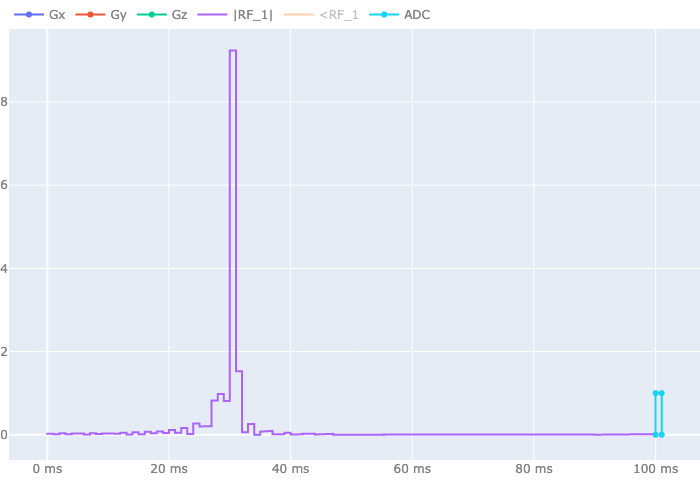

In [20]:
# plot
p1 = plot_seq(seq; slider = false, height = 300, max_rf_samples=Inf)

### Phantom

In [21]:
obj = Phantom{Float64}(name = "spin1", x = [0.], T1 = [50e-3], T2 = [25e-3]);

### Simulate

#### Signal

In [22]:
    # SIMULATE #
    signal1 = simulate(obj, seq, sys; simParams=Dict{String,Any}("return_type"=>"state"));

┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 2002
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.099364 seconds (390.72 k allocations: 18.803 MiB)


#### Signal to magnetization

In [23]:
signal = simulate(obj, seq, sys; simParams=Dict{String,Any}("return_type"=>"state"));
Mx = real(signal.xy)[];
My = imag(signal.xy)[];
Mz = signal.z[];
sig = "max"

┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 2002
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.092831 seconds (390.72 k allocations: 18.803 MiB)


"max"

#### Calculating the fidelity

In [32]:
# Fidelity
if sig == "max"
    Mxmax = Mmax[2, end]
    Mymax = Mmax[3, end]
    Mzmax = Mmax[4, end]
    fidelity_Mx = round(abs(Mx - Mxmax)*100, digits = 2)
    fidelity_My = round(abs(My - Mymax)*100, digits = 2)
    fidelity_Mz = round(abs(Mz - Mzmax)*100, digits = 2)
else 
    Mxmin = Mmin[2, end]
    Mymin = Mmin[3, end]
    Mzmin = Mmin[4, end]
    fidelity_Mx = round(abs(Mx - Mxmin)*100, digits = 2)
    fidelity_My = round(abs(My - Mymin)*100, digits = 2)
    fidelity_Mz = round(abs(Mz - Mzmin)*100, digits = 2)
end

0.75

In [33]:
println("Fidelity: Mx = $fidelity_Mx%, My = $fidelity_My%, Mz = $fidelity_Mz%")

Fidelity: Mx = 0.0%, My = 0.75%, Mz = 0.75%


### Magnetization dynamics

In [34]:
pieces = 100;
M_sp = zeros(Float64, 3, pieces);
t_koma = zeros(1, pieces);
for i in 1:pieces
    blocks = Int(length(RF_T)/pieces);
    rf = RF_T[1, 1:i*blocks] ;
    t_block = t_sp[1, i*blocks];

    #1st block -> RF block
    exc = RF(rf, t_block);
    
    # 2nd block -> ADC block
    nADC = 1 ;
    durADC = 1e-3 ;
    #delay = 1e-3 ;
    aqc = ADC(nADC, durADC)
    
    # concatenating the two blocks
    seq1  = Sequence();
    seq1 += exc;
    seq1 += aqc;
    #p1 = plot_seq(seq1; slider = false, height = 300, max_rf_samples=Inf)

    # PHANTOM #
    obj1 = Phantom{Float64}(name = "spin1", x = [0.], T1 = [100e-3], T2 = [50e-3]);

    # SIMULATE #
    signal1 = simulate(obj1, seq1, sys; simParams=Dict{String,Any}("return_type"=>"state"));

    # Magnetization
    M_sp[1, i] = real(signal1.xy)[];
    M_sp[2, i] = imag(signal1.xy)[];
    M_sp[3, i] = signal1.z[];

    # Time
    t_koma[1, i] = t_block;
end

  0.007416 seconds (224 allocations: 12.516 KiB)
  0.004480 seconds (6.42 k allocations: 332.031 KiB)
  0.002460 seconds (10.43 k allocations: 531.250 KiB)
  0.002898 seconds (14.31 k allocations: 720.219 KiB)
  0.003603 seconds (18.18 k allocations: 910.969 KiB)
  0.004382 seconds (22.07 k allocations: 1.076 MiB)
  0.004825 seconds (25.95 k allocations: 1.267 MiB)
  0.005510 seconds (29.83 k allocations: 1.449 MiB)
  0.006365 seconds (33.71 k allocations: 1.636 MiB)
  0.006907 seconds (37.59 k allocations: 1.822 MiB)
  0.007602 seconds (41.47 k allocations: 2.009 MiB)
  0.008317 seconds (45.35 k allocations: 2.196 MiB)
  0.009069 seconds (49.23 k allocations: 2.382 MiB)
  0.009766 seconds (53.11 k allocations: 2.569 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 2
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 22
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 42
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 62
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina

  0.010925 seconds (57.08 k allocations: 2.785 MiB)
  0.011634 seconds (60.87 k allocations: 2.942 MiB)
  0.013173 seconds (64.75 k allocations: 3.129 MiB)
  0.013274 seconds (68.63 k allocations: 3.317 MiB)
  0.014675 seconds (72.51 k allocations: 3.501 MiB)
  0.018681 seconds (76.39 k allocations: 3.688 MiB)
  0.015300 seconds (80.27 k allocations: 3.874 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 302
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 322
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 342
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 362
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.223776 seconds (84.24 k allocations: 4.084 MiB, 92.76% gc time)
  0.015377 seconds (88.03 k allocations: 4.248 MiB)
  0.015617 seconds (91.91 k allocations: 4.435 MiB)
  0.016537 seconds (95.79 k allocations: 4.623 MiB)
  0.017241 seconds (99.67 k allocations: 4.807 MiB)
  0.017946 seconds (103.55 k allocations: 4.994 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 442
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 462
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 482
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 502
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.018790 seconds (107.52 k allocations: 5.194 MiB)
  0.019800 seconds (111.31 k allocations: 5.367 MiB)
  0.021135 seconds (115.19 k allocations: 5.554 MiB)
  0.021483 seconds (119.07 k allocations: 5.742 MiB)
  0.021298 seconds (122.95 k allocations: 5.926 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 562
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 582
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 602
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 622
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.023012 seconds (126.92 k allocations: 6.126 MiB)
  0.023156 seconds (130.71 k allocations: 6.300 MiB)
  0.024435 seconds (134.59 k allocations: 6.487 MiB)
  0.024434 seconds (138.47 k allocations: 6.675 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 662
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 682
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 702
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 722
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.025201 seconds (142.44 k allocations: 6.872 MiB)
  0.025480 seconds (146.23 k allocations: 7.046 MiB)
  0.026903 seconds (150.11 k allocations: 7.233 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 742
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 762
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 782
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.027399 seconds (154.07 k allocations: 7.432 MiB)
  0.028022 seconds (157.87 k allocations: 7.605 MiB)
  0.029629 seconds (161.75 k allocations: 7.793 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 802
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 822
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 842
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045042 seconds (165.71 k allocations: 7.992 MiB)
  0.035964 seconds (169.51 k allocations: 8.165 MiB)
  0.032448 seconds (173.39 k allocations: 8.352 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 862
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 882
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 902
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.031973 seconds (177.36 k allocations: 8.552 MiB)
  0.032584 seconds (181.15 k allocations: 8.725 MiB)
  0.033938 seconds (185.03 k allocations: 8.912 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 922
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 942
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 962
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.033229 seconds (189.00 k allocations: 9.111 MiB)
  0.040728 seconds (192.79 k allocations: 9.284 MiB)
  0.035472 seconds (196.67 k allocations: 9.472 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 982
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1002
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1022
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.067573 seconds (200.64 k allocations: 9.671 MiB, 45.98% gc time)
  0.036274 seconds (204.43 k allocations: 9.844 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1042
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1062
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.037061 seconds (208.40 k allocations: 10.040 MiB)
  0.037877 seconds (212.19 k allocations: 10.217 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1082
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1102
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.037701 seconds (216.16 k allocations: 10.413 MiB)
  0.039379 seconds (219.95 k allocations: 10.590 MiB)
  0.039423 seconds (223.83 k allocations: 10.777 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1122
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1142
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1162
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.039903 seconds (227.80 k allocations: 10.977 MiB)
  0.041707 seconds (231.59 k allocations: 11.150 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1182
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1202
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.041132 seconds (235.56 k allocations: 11.346 MiB)
  0.043157 seconds (239.35 k allocations: 11.523 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1222
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1242
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.042036 seconds (243.31 k allocations: 11.719 MiB)
  0.044888 seconds (247.11 k allocations: 11.896 MiB)
  0.044914 seconds (250.99 k allocations: 12.083 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1262
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1282
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1302
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.046336 seconds (254.96 k allocations: 12.283 MiB)
  0.046243 seconds (258.75 k allocations: 12.456 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1322
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1342
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045954 seconds (262.72 k allocations: 12.652 MiB)
  0.047458 seconds (266.51 k allocations: 12.829 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1362
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1382
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.077596 seconds (270.48 k allocations: 13.025 MiB, 36.42% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1402
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.048197 seconds (274.35 k allocations: 13.210 MiB)
  0.050013 seconds (278.15 k allocations: 13.389 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1422
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1442
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.048115 seconds (282.12 k allocations: 13.585 MiB)
  0.064818 seconds (285.91 k allocations: 13.762 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1462
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1482
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.051064 seconds (289.88 k allocations: 13.958 MiB)
  0.052129 seconds (293.67 k allocations: 14.135 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1502
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1522
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.051902 seconds (297.64 k allocations: 14.331 MiB)
  0.053071 seconds (301.43 k allocations: 14.508 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1542
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1562
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.056025 seconds (305.40 k allocations: 14.704 MiB)
  0.054459 seconds (309.19 k allocations: 14.881 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1582
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1602
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.055869 seconds (313.16 k allocations: 15.077 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1622
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.055156 seconds (317.03 k allocations: 15.262 MiB)
  0.057084 seconds (320.83 k allocations: 15.441 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1642
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1662
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.083122 seconds (324.80 k allocations: 15.637 MiB, 29.82% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1682
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.058204 seconds (328.67 k allocations: 15.821 MiB)
  0.058947 seconds (332.47 k allocations: 16.000 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1702
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1722
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.057898 seconds (336.44 k allocations: 16.197 MiB)
  0.059557 seconds (340.23 k allocations: 16.374 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1742
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1762
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.059903 seconds (344.20 k allocations: 16.570 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1782
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.060975 seconds (348.06 k allocations: 16.754 MiB)
  0.062840 seconds (351.87 k allocations: 16.933 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1802
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1822
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.061777 seconds (355.84 k allocations: 17.130 MiB)
  0.063517 seconds (359.63 k allocations: 17.306 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1842
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1862
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.064614 seconds (363.60 k allocations: 17.502 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1882
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.063160 seconds (367.48 k allocations: 17.687 MiB)
  0.066304 seconds (371.27 k allocations: 17.865 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1902
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1922
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.093989 seconds (375.24 k allocations: 18.062 MiB, 28.05% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1942
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.079443 seconds (379.12 k allocations: 18.246 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1962
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.068443 seconds (383.00 k allocations: 18.433 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1982
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.068902 seconds (386.87 k allocations: 18.620 MiB)


In [35]:
# Magnetization values
My_koma = M_sp[2,:]';
Mz_koma = M_sp[3,:]';

t_evol = LinRange(0.0, tf_sp, Int(length(RF_T)+1));

#### Plot

In [36]:
plotly();
p_mag = plot(t_evol, Mmax[4,:], line=:solid, marker=:circle, label = "OC Grape");
plot!(t_koma', Mz_koma', seriestype=:line, marker=:circle, label = "KomaMRI");

In [37]:
display(p_mag)